#### VGG16
VGG16 has a total of 138 million parameters. The important point to note here is that all the conv kernels are of size 3x3 and maxpool kernels are of size 2x2 with a stride of two.

![image](network.png)

The idea behind having fixed size kernels is that all the variable size convolutional kernels used in Alexnet (11x11, 5x5, 3x3) can be replicated by making use of multiple 3x3 kernels as building blocks. The replication is in terms of the receptive field covered by the kernels.



In [1]:
import torch
import torch.nn as nn
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader,random_split
from torchvision import transforms

def get_dataloaders(datasetname, batch_size, validation_fraction=0.2, train_transforms=transforms.ToTensor(), test_transforms=transforms.ToTensor()):
    # Load train and test datasets
    if datasetname == 'CIFAR10':
        train_dataset = datasets.CIFAR10(root='data', train=True, transform=train_transforms, download=True)
        test_dataset = datasets.CIFAR10(root='data', train=False, transform=test_transforms)
    else: # MNIST
        train_dataset = datasets.MNIST(root='data', train=True, transform=train_transforms, download=True)
        test_dataset = datasets.MNIST(root='data', train=False, transform=test_transforms)

    # Split train dataset into train and validation subsets
    train_size = int((1 - validation_fraction) * len(train_dataset))
    valid_size = len(train_dataset) - train_size
    train_subset, val_subset = random_split(train_dataset, [train_size, valid_size])

    # Create data loaders for each subset
    train_loader = DataLoader(train_subset, batch_size, shuffle=True)
    valid_loader = DataLoader(val_subset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

    return train_loader, valid_loader, test_loader

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

def compute_accuracy(model, data_loader, device):
    with torch.no_grad():    
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()

        return correct_pred.float()/num_examples * 100

d:\Adams\Anaconda\envs\gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### SETTINGS
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
set_seed(123)


### CIFAR10 DATASET
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader, valid_loader, test_loader = get_dataloaders('CIFAR10', batch_size=BATCH_SIZE, validation_fraction=0.1, train_transforms=train_transforms, test_transforms=test_transforms)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([2, 7, 4, 7, 0, 1, 1, 6, 9, 2])


##### VGG Network
![image](parameters.png)

In [3]:
class Block2C(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
    def forward(self, x):
        return self.block(x)
    
class Block3C(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
    def forward(self, x):
        return self.block(x)
    
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.block_1 = Block2C(3, 64)
        self.block_2 = Block2C(64, 128)
        self.block_3 = Block3C(128,256)
        self.block_4 = Block3C(256, 512)
        self.block_5 = Block3C(512, 512)
        height,width = 3, 3
        self.avgpool = torch.nn.AdaptiveAvgPool2d((height, width))
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512*height*height, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes))
        
        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
        
    def forward(self, x):                       #[n, 3, 64, 64]

        x = self.block_1(x)                     #[n, 64, 32, 32]
        x = self.block_2(x)                     #[n, 128, 16, 16]
        x = self.block_3(x)                     #[n, 256, 8, 8]
        x = self.block_4(x)                     #[n, 512, 4, 4]
        x = self.block_5(x)                     #[n, 512, 2, 2]
        x = self.avgpool(x)                     #[n, 512, 3, 3]
        x = x.view(x.size(0), -1) # flatten     #[n, 4608]
        
        logits = self.classifier(x)

        return logits 

In [8]:
#check if cuda available
print(torch.__version__)
print(torch.version.cuda)

import time
model = VGG16(num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max', verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
start_time = time.time()

for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # ## FORWARD AND BACK PROP
        logits = model(features)
        loss = torch.nn.functional.cross_entropy(logits, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ## LOGGING
        minibatch_loss_list.append(loss.item())
        if not batch_idx % 100:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Batch {batch_idx:04d}/{len(train_loader):04d} | Loss: {loss:.4f}')

    model.eval()
    train_acc = compute_accuracy(model, train_loader, device=DEVICE)
    valid_acc = compute_accuracy(model, valid_loader, device=DEVICE)
    print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | Train: {train_acc :.2f}% | Validation: {valid_acc :.2f}%')
    train_acc_list.append(train_acc.item())
    valid_acc_list.append(valid_acc.item())
    
    scheduler.step(valid_acc_list[-1])

elapsed = (time.time() - start_time)/60
print(f'Time elapsed: {elapsed:.2f} min')

test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Test accuracy {test_acc :.2f}%')

1.13.1
11.7
Epoch: 001/050 Batch 0000/0176 | Loss: 3.1487
Epoch: 001/050 Batch 0100/0176 | Loss: 2.2640
Epoch: 001/050 | Train: 29.10% | Validation: 27.58%
Epoch: 002/050 Batch 0000/0176 | Loss: 1.9843
Epoch: 002/050 Batch 0100/0176 | Loss: 1.6544
Epoch: 002/050 | Train: 40.63% | Validation: 39.72%
Epoch: 003/050 Batch 0000/0176 | Loss: 1.6040
Epoch: 003/050 Batch 0100/0176 | Loss: 1.4267
Epoch: 003/050 | Train: 51.63% | Validation: 49.62%
Epoch: 004/050 Batch 0000/0176 | Loss: 1.3664
Epoch: 004/050 Batch 0100/0176 | Loss: 1.2943
Epoch: 004/050 | Train: 53.64% | Validation: 51.44%
Epoch: 005/050 Batch 0000/0176 | Loss: 1.3259
Epoch: 005/050 Batch 0100/0176 | Loss: 1.0424
Epoch: 005/050 | Train: 65.16% | Validation: 62.46%
Epoch: 006/050 Batch 0000/0176 | Loss: 1.0117
Epoch: 006/050 Batch 0100/0176 | Loss: 1.0096
Epoch: 006/050 | Train: 70.22% | Validation: 67.30%
Epoch: 007/050 Batch 0000/0176 | Loss: 0.7701
Epoch: 007/050 Batch 0100/0176 | Loss: 0.8412
Epoch: 007/050 | Train: 75.06% |

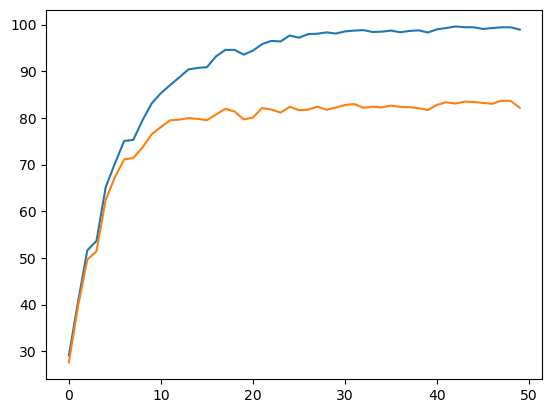

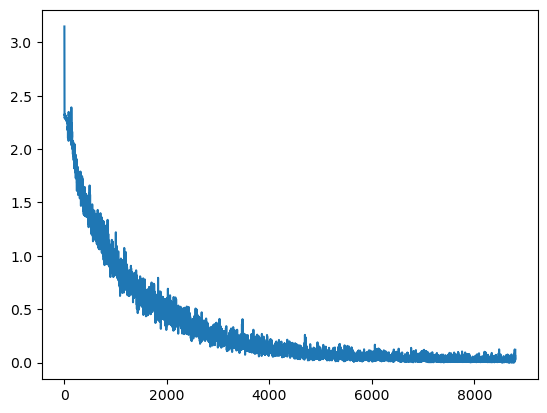

In [9]:
plt.plot(train_acc_list, label='train accuracy')
plt.plot(valid_acc_list, label='train accuracy')
plt.show()

plt.plot(minibatch_loss_list, label='loss')
plt.show()